## Data Exploration

### Perform exploratory data analysis on highlights and fulltexts of articles from Medium.com

Before trying to train a model, I performed exploratory analysis to visualize features of sentences from the corpus that I had scraped from Medium.com.

In [4]:
import os, time, re, pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import timedelta, date
import urllib
import html5lib
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, SoupStrainer


### NOTES
* FIND DUPLICATES

* To calculate:

   * Length of highlight

   * Find highlight in fulltext (calculate when it starts, as percentage) -- break fulltext and highlight into words?

   * Percent length of highlight in fulltext

   * TF/IDF

   * Grade level of fulltext and highlight
   

### CHECK LENGTH OF HIGHLIGHTS



articles without highlights: 391
articles with highlights: 1993
['Until you appreciate what you currently have, more won’t make your life better.', 'And let’s not feel terrified, but full of renewed solidarity for one another as terrorists try\u200a—\u200aand fail\u200a—\u200ato spread terror.', 'Hard work is doing the work other people don’t want to do.', 'He’d made up his mind to skip the dog thing altogether, decided to collect pussy cats instead, something like that.', 'Realizing that our actions, feelings and behaviour are the result of our own images and beliefs gives us the level that psychology has always needed for changing personality.', 'So, the advice I have is to find what your north star is, to understand yourself, to understand what your work/life balance and ambitions are. What your financial ambitions are. What your life challenges are. The problems that you want to try and solve. The mountains that you want to climb while you’re here. You can’t listen to anyone else. 

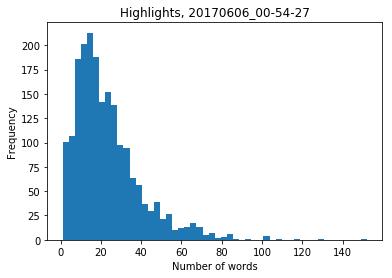

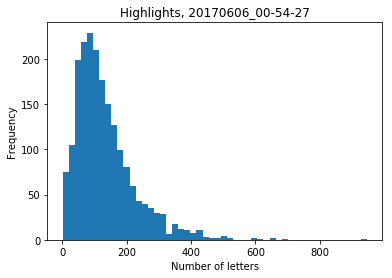

In [3]:
with open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/highlights_20170606_00-54-27.txt','r') as fhigh:
    hlist = fhigh.readlines()
    
matword = []
matchar = []
id_hl = []
id_no = []
ct_hl = 0
ct_no = 0
htext = []

for line in hlist:
    
    # Analyze length of highlights and number of lines with highlights
    line = line.strip().split('\t')
    if len(line) <= 2:
        id_no.append(line[1])
        ct_no += 1
    else:
        lenword = len(line[2].split())
        lenchar = len(line[2])
        # print( line )
        # print( length )
        matword.append(lenword)
        matchar.append(lenchar)
        id_hl.append(line[1])
        htext.append(line[2])
        ct_hl += 1
        
print( 'articles without highlights: '+str(ct_no) )
print( 'articles with highlights: '+str(ct_hl) )
print( htext[:10] )
print( id_hl[:10] )

plt.hist(matword, bins=50)
plt.title("Highlights, 20170606_00-54-27")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

plt.hist(matchar, bins=50)
plt.title("Highlights, 20170606_00-54-27")
plt.xlabel("Number of letters")
plt.ylabel("Frequency")
plt.show()


### CHECK FOR DUPLICATES

Because I scraped 30 popular articles per day with only 5 days between, some articles might be duplicates. Here, check for duplicates in the dataset.

66
If you want to be good at something, do it every day. No exceptions. You can use your time effectively and productivity if you are consistent.


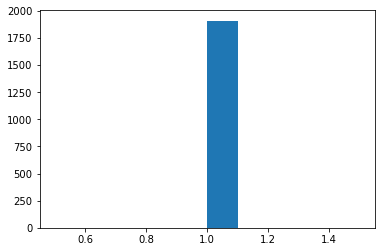

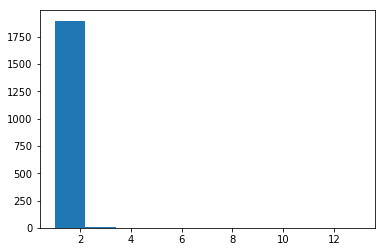

number of unique highlights: 1908
number of non-unique highlights: 85


In [4]:
seen = set()
seen_add = seen.add

htext_uniq = []
id_hl_uniq = []    # store ids of first unique highlights
id_hl_nonu = []    # store ids of non-unique highlights
idnum = 0

for x in htext:    # get unique highlights, preserving order
    if x in seen:
        id_hl_nonu.append(id_hl[idnum])
        idnum += 1
        continue
    seen_add(x)
    htext_uniq.append(x)
    id_hl_uniq.append(id_hl[idnum])
    idnum += 1

print(id_hl_uniq[49])    # check that id_hl_uniq matches htext_uniq -- it does!!
print(htext_uniq[49])
counts = []
counts2 = []
for x in htext_uniq:
    counts.append(htext_uniq.count(x))
    counts2.append(htext.count(x))
plt.hist(counts)
plt.show()
plt.hist(counts2)
plt.show()

print('number of unique highlights: '+str(len(id_hl_uniq)))
print('number of non-unique highlights: '+str(len(id_hl_nonu)))


### RE-CHECK LENGTH OF HIGHLIGHTS AFTER REMOVING DUPLICATES

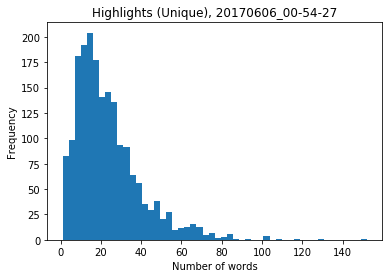

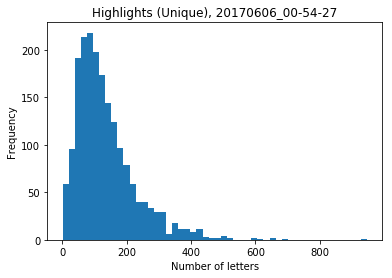

In [5]:
matword_uniq = []
matchar_uniq = []
idnum = 0
for line in htext_uniq:
#     print(id_hl_uniq[idnum]+'\t'+line)
#     print(htext_uniq)
    lenword = len(line.split())
    matword_uniq.append(lenword)
    lenchar = len(line)
    matchar_uniq.append(lenchar)
    idnum += 1
    
plt.hist(matword_uniq, bins=50)
plt.title("Highlights (Unique), 20170606_00-54-27")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

plt.hist(matchar_uniq, bins=50)
plt.title("Highlights (Unique), 20170606_00-54-27")
plt.xlabel("Number of letters")
plt.ylabel("Frequency")
plt.show()


### CLEAN UP FULLTEXT

Get full text of article from html.

* note: fixed to avoid getting comments as well as main text



In [25]:
fhtml = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/fullhtml_20170606_00-54-27_isolate.txt','r')

id_ft = []
fullt = []

# num = 0
for line in fhtml:
    text = line.strip().split('\t')
    fullh = text[2]
    fullt_line = []

    # testing SoupStrainer
# #     content = SoupStrainer('div',attrs={'data-source':'post_page'})
#     soup = BeautifulSoup(fullh,'lxml')#,parse_only=content)
#     txt0 = soup.find('div',attrs={'data-source':'post_page'})#class_='postArticle-content')
# #     print(txt0)
#     txt1 = txt0.find_all('p',class_='graf')
# #     print(txt1)

    soup = BeautifulSoup(fullh,'lxml')                            #,parse_only=content)
    txt0 = soup.find('div',attrs={'data-source':'post_page'})     #class_='postArticle-content')
    if not txt0:
        print('error! skipping '+text[1])
        continue
    txt1 = txt0.find_all('p',class_='graf')
    id_ft.append(text[1])

    for line in txt1:
        txt2 = re.sub('<[^>]+>', '', str(line) )
        fullt_line.append(txt2)
#     num+=1
#     if num == 10:
#         break

#     print(fullt_line)
    
    fullt.append( fullt_line )

print(id_ft[2])
print(fullt[2])

    
# fhtmldelim.write('\t'.join(fullh))
# fhtmldelim.close()



error! skipping 46
error! skipping 63
error! skipping 79
error! skipping 102
error! skipping 104
error! skipping 132
error! skipping 137
error! skipping 146
error! skipping 151
error! skipping 193
error! skipping 211
error! skipping 233
error! skipping 255
error! skipping 259
error! skipping 265
error! skipping 271
error! skipping 310
error! skipping 313
error! skipping 322
error! skipping 323
error! skipping 329
error! skipping 440
error! skipping 464
error! skipping 500
error! skipping 557
error! skipping 569
error! skipping 607
error! skipping 609
error! skipping 626
error! skipping 656
error! skipping 676
error! skipping 689
error! skipping 693
error! skipping 719
error! skipping 727
error! skipping 735
error! skipping 786
error! skipping 802
error! skipping 817
error! skipping 825
error! skipping 834
error! skipping 855
error! skipping 881
error! skipping 894
error! skipping 908
error! skipping 918
error! skipping 929
error! skipping 972
error! skipping 981
error! skipping 985
err

### Check that id_ft matches fullt matches id_hl_uniq matches htext_uniq -- all good!!

In [27]:
print(id_ft[64])
print(fullt[64])


67
['Hot on the heels of Sketch 43, we’ve used this release to focus on one of Sketch’s most fundamental features\u200a—\u200aArtboards. We’ve also added better support for missing fonts, dramatically improved resizing controls and added a great new feature to Sketch Cloud. Here’s an overview of the headline updates in Sketch 44:', 'They might not be the most exciting feature, but Artboards are a common starting point for so many Sketch projects. They’re already pretty flexible, but we figured they could do more for you in Sketch 44.', 'With this release, we’ve redesigned the Artboard picker to make it clearer and more flexible. We’ve simplified that long list of Artboard presets\u200a—\u200asplitting them up into categories that you can select using a drop-down menu. Also, instead of having a preset for each orientation of a device, you can now select portrait or landscape using a set of dedicated buttons. The result? Creating and controlling Artboards is now quicker and easier than e

### CHECK LENGTH OF HIGHLIGHTS for second dataset

As mentioned before, I originally scraped articles with 10 days' spacing; now, scrape more articles with 10 days' spacing except offset by 5 days relative to original dates scraped.

articles without highlights: 297
articles with highlights: 1879
['If you continue to treat as many of the people you meet with kindness as you can, over the course of time, you will create a better world. Take the pressure off.', 'Getting where you want to be isn’t always about accumulating things, sometimes it’s about letting things go, learning to be more content, and being a more compassionate person.', '“Every next level of your life will demand a different you.”\u200a—\u200aLeonardo DiCaprio', 'Prioritize placing buttons at the bottom of the screen.', 'Amazon gives you the online price if you’re a Prime member, but the jacket price if you’re not.', 'I basically learned programming through just random online resources and books, but an important way that I learned was just by reading other people’s code.', 'When you focus on the process, the outcome will follow automatically.', 'It’s all proven to me that the collective power of human ambition cannot be stopped and it cannot be con

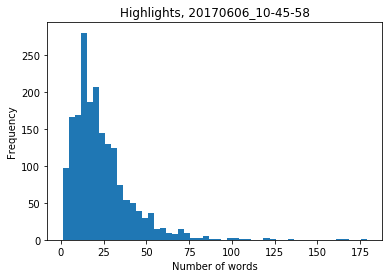

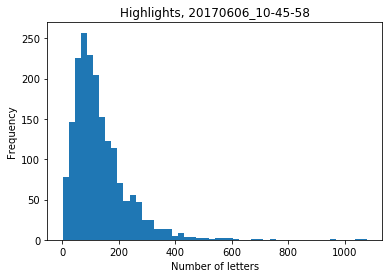

In [16]:

with open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/highlights_20170606_10-45-58.txt','r') as fhigh2:
    hlist2 = fhigh2.readlines()
    
matword2 = []
matchar2 = []
id_hl2 = []
id_no2 = []
ct_hl2 = 0
ct_no2 = 0
htext2 = []

for line in hlist2:
    
    # Analyze length of highlights and number of lines with highlights
    line = line.strip().split('\t')
    if len(line) <= 2:
        id_no2.append(str(int(line[1])+2384))
        ct_no2 += 1
    else:
        lenword2 = len(line[2].split())
        lenchar2 = len(line[2])
        # print( line )
        # print( length )
        matword2.append(lenword2)
        matchar2.append(lenchar2)
        id_hl2.append(str(int(line[1])+2384))
        htext2.append(line[2])
        ct_hl2 += 1
        
print( 'articles without highlights: '+str(ct_no2) )
print( 'articles with highlights: '+str(ct_hl2) )
print( htext2[:10] )
print( id_hl2[:10] )

plt.hist(matword2, bins=50)
plt.title("Highlights, 20170606_10-45-58")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.show()

plt.hist(matchar2, bins=50)
plt.title("Highlights, 20170606_10-45-58")
plt.xlabel("Number of letters")
plt.ylabel("Frequency")
plt.show()


### CLEAN UP FULLTEXT for second dataset


In [29]:

fhtml2 = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/fullhtml_20170606_10-45-58_edit_isolate.txt','r')

id_ft2 = []
fullt2 = []

# num = 0
for line in fhtml2:
    text = line.strip().split('\t')
    fullh = text[2]
    fullt_line = []

#     insetCol = SoupStrainer('div',{'class':'section-inner sectionLayout--insetColumn'})
    soup = BeautifulSoup(fullh,'lxml')                            #,parse_only=content)
    txt0 = soup.find('div',attrs={'data-source':'post_page'})     #class_='postArticle-content')
    if not txt0:
        print('error! skipping '+text[1])
        continue
    txt1 = txt0.find_all('p',class_='graf')
    id_ft2.append(str(int(text[1])+2384))

#     soup = BeautifulSoup(fullh,'lxml')#,parse_only=insetCol)
#     txt0 = soup.find('div',class_='section-inner sectionLayout--insetColumn')
#     txt1 = txt0.find_all('p',class_='graf')

    for line in txt1:
        txt2 = re.sub('<[^>]+>', '', str(line) )
        fullt_line.append(txt2)

#     print(fullt_line)
    fullt2.append( fullt_line )
#     num+=1
#     if num == 22:
#         break

print(id_ft2[9])
print(fullt2[9])
print(id_ft2)
print(str(len(id_ft2)))
print(str(len(fullt2)))

    
# fhtmldelim.write('\t'.join(fullh))
# fhtmldelim.close()


error! skipping 20
error! skipping 68
error! skipping 70
error! skipping 121
error! skipping 180
error! skipping 237
error! skipping 257
error! skipping 266
error! skipping 287
error! skipping 298
error! skipping 302
error! skipping 317
error! skipping 333
error! skipping 380
error! skipping 382
error! skipping 400
error! skipping 422
error! skipping 439
error! skipping 441
error! skipping 450
error! skipping 482
error! skipping 523
error! skipping 532
error! skipping 544
error! skipping 556
error! skipping 584
error! skipping 594
error! skipping 615
error! skipping 638
error! skipping 660
error! skipping 684
error! skipping 705
error! skipping 707
error! skipping 708
error! skipping 731
error! skipping 739
error! skipping 771
error! skipping 776
error! skipping 843
error! skipping 863
error! skipping 873
error! skipping 881
error! skipping 890
error! skipping 904
error! skipping 924
error! skipping 946
error! skipping 949
error! skipping 951
error! skipping 962
error! skipping 970
err

### COMBINE DATASETS 1 AND 2

In [ ]:
id_ft_all = id_ft + id_ft2
fullt_all = fullt + fullt2

id_hl_all = id_hl + id_hl2
htext_all = htext + htext2

print(str(len(id_ft)))
print(str(len(id_ft2)))
print(str(len(id_ft_all)))
print(str(len(fullt)))
print(str(len(fullt2)))
print(str(len(fullt_all)))

print(str(len(id_hl)))
print(str(len(id_hl2)))
print(str(len(id_hl_all)))
print(str(len(htext)))
print(str(len(htext2)))
print(str(len(htext_all)))

print(str(id_ft[-1]))

### CHECK FOR DUPLICATES AFTER COMBINING DATASETS

66
If you want to be good at something, do it every day. No exceptions. You can use your time effectively and productivity if you are consistent.


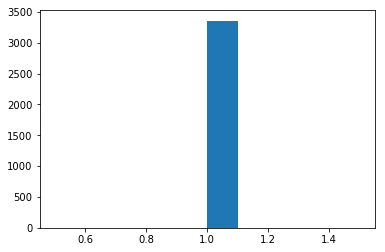

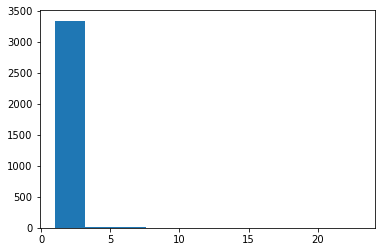

number of unique highlights: 3357
number of non-unique highlights: 515


In [33]:

seen = set()
seen_add = seen.add

htext_unq = []
id_hl_unq = []    # store ids of first unique highlights
id_hl_non = []    # store ids of non-unique highlights
idnum = 0

for x in htext_all:    # get unique highlights, preserving order
    if x in seen:
        id_hl_non.append(id_hl_all[idnum])
        idnum += 1
        continue
    seen_add(x)
    htext_unq.append(x)
    id_hl_unq.append(id_hl_all[idnum])
    idnum += 1

print(id_hl_unq[49])    # check that id_hl_uniq matches htext_uniq -- it does!!
print(htext_unq[49])
counts = []
counts2 = []
for x in htext_unq:
    counts.append(htext_unq.count(x))
    counts2.append(htext_all.count(x))
plt.hist(counts)
plt.show()
plt.hist(counts2)
plt.show()

print('number of unique highlights: '+str(len(id_hl_unq)))
print('number of non-unique highlights: '+str(len(id_hl_non)))


### Create dictionaries to identify only articles containing a top highlight

• combine highlights+ids in dict, fulltext+ids in dict; compare and pull out only fulltext with highlights

In [86]:

keys_fullt = id_ft_all
vals_fullt = fullt_all
dict_fullt = dict(zip(keys_fullt,vals_fullt))

keys_htext = id_hl_unq
vals_htext = htext_unq
dict_htext = dict(zip(keys_htext,vals_htext))

keysf = set(dict_fullt.keys())
keysh = set(dict_htext.keys())
intersect = keysf & keysh
# print(intersect)

print(len(keysf))
print(len(keysh))
print(len(intersect))

interx = list(map(int,intersect))
interx.sort()
interx = list(map(str,interx))
# print(interx)

keys_h = []
vals_h = []
keys_f = []
vals_f = []
for i in interx:
    keys_h.append(i)
    vals_h.append(dict_htext[i])
    keys_f.append(i)
    vals_f.append(dict_fullt[i])

dict_h = dict(zip(keys_h,vals_h))
dict_f = dict(zip(keys_f,vals_f))

print(len(keys_h))
print(len(vals_h))
print(len(keys_f))
print(len(vals_f))

keys_h == keys_f # True

vals_all = zip(vals_h, vals_f)
dict_all = dict(zip(keys_h, vals_all))

dict_all['2']


4341
3357
3201
3201
3201
3201
3201


### Save dict_all with pickle


In [89]:
# fdict_all = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/dict_all','wb')
# pickle.dump(dict_all, fdict_all)


True

### retrieve with pickle


In [9]:
dict_temp = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/dict_all','rb'))

# dict_temp == dict_all

### Write to files



In [81]:
file_high = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/final_highlights.txt','w')
file_full = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/final_fulltext.txt','w')
file_all = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/final_all.txt','w')

for i in interx:
    file_high.write(i+'\t'+dict_h[i]+'\n')
    file_full.write(i+'\t'+'|'.join(dict_f[i])+'\n')
    file_all.write(i+'\t'+dict_h[i]+'\t'+'|'.join(dict_f[i])+'\n')

file_high.close()
file_full.close()
file_all.close()

In [207]:
# DELETE HIGHLIGHTS FROM FULLTEXT SENTENCES

n = 0
sent_all = []
for i in data['ids']:
    full = str(' '.join(data['text'][n]))
    high = data['highlights'][n]
    fnoh = full.replace(high,' ')

    sent = tokenizer.tokenize(fnoh)
    for j in sent: 
        sent_all.append(j)    # collect all sentences from all full texts into one list

    n+=1

print(len(sent_all))

238462


### Save all sentences with pickle and save dataframe with pickle

In [209]:
fsent_all = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/sent_all','wb')
pickle.dump(sent_all, fsent_all)



In [214]:
# data = pd.DataFrame({'ids':keys_h, 'highlights':vals_h, 'text':vals_f})
fdata = open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/data_pd','wb')
pickle.dump(data,fdata)

In [215]:
data_temp = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/data_pd','rb'))
data_temp == data

,highlights,ids,text
0,True,True,True
1,True,True,True
2,True,True,True
3,True,True,True
4,True,True,True
5,True,True,True
6,True,True,True
7,True,True,True
8,True,True,True
9,True,True,True


### REANALYSIS - 6/8/2017

#### load dict_all from pickled file as dict_temp

In [17]:
# print(dict_temp['2'])
keys = []
vals_h = []
vals_f = []
for key, val in dict_temp.items():
    keys.append(key)
    vals_h.append(val[0])
    vals_f.append(val[1])
data_tmp = pd.DataFrame({'ids':keys, 'highlights':vals_h, 'text':vals_f})

data_temp = pickle.load(open('/Users/clarencecheng/Dropbox/~Insight/skimr/datasets/data_pd','rb'))
data_tmp == data_temp
data_tmp.equals(data_temp)



True

### FIND HIGHLIGHT IN FULL TEXT (START AND END POSITION)

* calculate fraction of way through document (in sentences) (maybe words later?) (why not characters?)
* calculate fraction length (highlight / document) (in words and sentences)


In [ ]:
import nltk.data

# # read dict_all into list
# data = [(k,v) for k,v in dict_all.items()]
# # d_high = data[1][0]
# # print(data[1])

# READ dict_all into pandas
sent_join = []

# CONVERT list of paragraphs in 'text' column into string containing all text
for i in data['text']:
    sent = str(' '.join(i))
    sent_join.append(str(sent))
# print(sent) # '\u200a' appears when not using print fxn
# sent
# print(sent_join[-1])
# sent_join[-1]

# BREAK text into sentences and find fraction of sentences into text that highlight appears
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

n = 0
count_in = 0
count_out = 0
lenfs = []
poshs = []
fracs = []
# sent_all = []
for i in data['ids']:
    full = str(' '.join(data['text'][n]))
    sent = tokenizer.tokenize(full)
#     for j in sent: 
#         sent_all.append(j)    # collect all sentences from all full texts into one list
    lenf = len(sent)
    lenfs.append(lenf)
    high = tokenizer.tokenize(data['highlights'][n])
    try:
        posh = sent.index(high[0])
        poshs.append(posh)
        fracs.append(posh/lenf)
#         print('highlight pos: '+str(posh)+'\tnumber of sent: '+str(lenf)+'\tfraction: '+str(posh/lenf))
        count_in += 1
    except ValueError:
#         print('highlight not in sentence list!')
        count_out += 1
        pass
    n += 1
#     if n == 6:
#         break
    
print(count_in)
print(count_out)

# print(len(sent_all))




### ALTERNATIVE:

* Find fraction of words into text that highlight appears, then...
* Find which sentence num that word belongs to and calc sentence fraction for highlight
